In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os

import pickle
from pickle import load

import numpy as np
import tensorflow as tf

from skimage.transform import resize

from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def mostrar_img_blue(img, titulo = ''):
  plt.axis("off")
  plt.suptitle(titulo)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
def mostrar_img(img, titulo = ''):
  plt.axis("off")
  plt.suptitle(titulo)
  plt.imshow(img)
  plt.show()

In [ ]:
def salvar_modelo_treino(caminho, arquivo):
  pickle_data = open(caminho, 'wb')
  pickle.dump(arquivo, pickle_data)
  pickle_data.close()

In [ ]:
def carregar_modelo(caminho):
  modelo = load(open(caminho, 'rb'))
  return modelo

In [ ]:
def carregar_imagens_rotulos(caminho, pastas, tamanho_imagem):
  imagens = []
  rotulos = []

  for rotulo, pasta in enumerate(pastas):
    pasta_imagem = caminho + '/' + pasta
    nome_imagens = os.listdir(pasta_imagem)

    for nome_imagem in nome_imagens:
      caminho_imagem = pasta_imagem + '/' + nome_imagem

      imagem = cv2.imread(caminho_imagem)
      imagem = np.array(imagem, dtype=np.uint8)
      imagem_normalizada = cv2.resize(imagem, tamanho_imagem)

      imagens.append(imagem_normalizada)
      rotulos.append(rotulo)

  imagens = np.array(imagens)
  rotulos = np.array(rotulos)

  return imagens, rotulos

In [ ]:
def treino_split(imagens, rotulos):
  X_treino, X_teste, y_treino, y_teste = train_test_split(imagens, rotulos, test_size=0.2, random_state=42)

  X_treino = X_treino.astype('float32') / 255.0
  X_teste = X_teste.astype('float32') / 255.0

  return X_treino, X_teste, y_treino, y_teste

In [ ]:
def criar_classe_resnet(tamanho_imagem, num_classes, tamanho_kernel, tamanho_pool, tamanho_passos):
  resnet = ResNet50(weights=None, include_top=False, input_shape=tamanho_imagem)
  keras_input = tf.keras.Input(shape=tamanho_imagem)

  x = resnet.output

  x = Dense(256, activation='relu')(x)
  x = layers.Conv2D(64, kernel_size=tamanho_kernel, strides=tamanho_passos, padding='same')(keras_input)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.MaxPooling2D(pool_size=tamanho_pool, strides=tamanho_passos, padding='same')(x)
  x = GlobalAveragePooling2D()(x)

  predicoes = Dense(num_classes, activation='softmax')(x)

  modelo = tf.keras.Model(inputs=keras_input, outputs=predicoes)

  return modelo

In [ ]:
def usar_classificador_resnet(imagens, rotulos, num_classes, tamanho_kernel, tamanho_pool, tamanho_passos, taxa_aprendizado = 0.0001):
  shape = imagens[0].shape
  X_treino, X_teste, y_treino, y_teste = treino_split(imagens, rotulos)

  X_treino = X_treino.astype(np.float32)
  X_teste = X_teste.astype(np.float32)

  X_treino = np.array([resize(imagem, (shape[0], shape[1])) for imagem in X_treino])
  X_teste = np.array([resize(imagem, (shape[0], shape[1])) for imagem in X_teste])

  y_treino = tf.keras.utils.to_categorical(y_treino, num_classes)
  y_teste = tf.keras.utils.to_categorical(y_teste, num_classes)

  classificador_base = criar_classe_resnet(shape, num_classes, tamanho_kernel, tamanho_pool, tamanho_passos)
  classificador_gradiente = criar_classe_resnet(shape, num_classes, tamanho_kernel, tamanho_pool, tamanho_passos)
  classificador_adam = criar_classe_resnet(shape, num_classes, tamanho_kernel, tamanho_pool, tamanho_passos)

  tipo_de_perda = 'categorical_crossentropy'

  classificador_base.compile(optimizer='adam', loss=tipo_de_perda, metrics=['accuracy'])
  classificador_gradiente.compile(optimizer=SGD(learning_rate=taxa_aprendizado), loss=tipo_de_perda, metrics=['accuracy'])
  classificador_adam.compile(optimizer=Adam(learning_rate=taxa_aprendizado), loss=tipo_de_perda, metrics=['accuracy'])

  print(X_treino.shape)
  print(y_treino.shape)

  print("Classificador Base:\n")
  classificador_base.summary()

  print("\nClassificador Gradiente:\n")
  classificador_gradiente.summary()

  print("\nClassificador Adam:\n")
  classificador_adam.summary()

  return classificador_base, classificador_gradiente, classificador_adam, X_treino, X_teste, y_treino, y_teste

In [ ]:
def gerar_grafico(plots, titulo, valor_x, valor_y, legendas):
  cores = ['b', 'r', 'g', 'w', 'k', 'w', 'm', 'c']
  index = 0

  for plot in plots:
    plt.plot(plot, color=cores[index])
    index += 1

  plt.title(titulo)
  plt.xlabel(valor_x)
  plt.ylabel(valor_y)
  plt.legend(legendas, loc='upper left')
  plt.show()

In [ ]:
def mostrar_resultado_modelo(titulo, acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas):
  print("----------------------------RESULTADO-MODELOS----------------------------\n")

  print(f"--{titulo}--\n")

  acuracias = [f"{acuracia * 100:.2f}%" for acuracia in acuracia_treino]
  print(f"Acurácias durante o treinamento:\n{acuracias}\n")

  perdas = [f"{perda:.2f}" for perda in acuracia_perda]
  print(f"Perdas durante o treinamento:\n{perdas}\n")

  print()
  gerar_grafico([acuracia_treino, epocas_treino], "Acurácia", "Época", "Acurácia", ["Treinamento", "Validação"])
  print()
  gerar_grafico([acuracia_perda, acuracia_epocas], "Perda", "Época", "Perda", ["Treinamento", "Validação"])

In [ ]:
def treinar_modelo(classificador, X_treino, X_teste, y_treino, y_teste, epocas = 10, tamanho_batches = 32):
  modelo = classificador.fit(X_treino, y_treino, validation_data=(X_teste, y_teste), epochs=epocas, batch_size=tamanho_batches)

  return modelo

In [ ]:
caminho_base = '/content/drive/MyDrive/Faculdade/VisaoComputacional/TrabalhoBimestral-2'
pastas = ['acai', 'coffee', 'guarana', 'strawberry', 'watermelon', 'pineapple', 'lemon', 'cherry', 'banana', 'avocado']

In [ ]:
todas_imagens, rotulos = carregar_imagens_rotulos(caminho_base, pastas, (124, 124))

In [ ]:
#Classificador Resnet:
classificador_resnet_base, classificador_resnet_gradiente, classificador_resnet_adam, resnet_X_treino, resnet_X_teste, resnet_y_treino, resnet_y_teste = usar_classificador_resnet(todas_imagens, rotulos, len(pastas), (7, 7), (3, 3), (2, 2))

(8140, 124, 124, 3)
(8140, 10)
Classificador Base:

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        9472      
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 global_a

In [ ]:
resnet_treino_base = treinar_modelo(classificador_resnet_base, resnet_X_treino, resnet_X_teste, resnet_y_treino, resnet_y_teste, epocas = 20)

Epoch 1/20
255/255 [==============================] - 13s 15ms/step - loss: 1.8760 - accuracy: 0.3500 - val_loss: 1.9071 - val_accuracy: 0.3374
Epoch 2/20
255/255 [==============================] - 3s 12ms/step - loss: 1.7233 - accuracy: 0.4135 - val_loss: 1.7220 - val_accuracy: 0.4170
Epoch 3/20
255/255 [==============================] - 4s 14ms/step - loss: 1.6590 - accuracy: 0.4501 - val_loss: 1.6415 - val_accuracy: 0.4253
Epoch 4/20
255/255 [==============================] - 3s 13ms/step - loss: 1.6147 - accuracy: 0.4561 - val_loss: 1.6032 - val_accuracy: 0.4686
Epoch 5/20
255/255 [==============================] - 3s 13ms/step - loss: 1.5757 - accuracy: 0.4784 - val_loss: 1.7549 - val_accuracy: 0.3723
Epoch 6/20
255/255 [==============================] - 3s 11ms/step - loss: 1.5494 - accuracy: 0.4828 - val_loss: 1.6385 - val_accuracy: 0.4361
Epoch 7/20
255/255 [==============================] - 3s 13ms/step - loss: 1.5232 - accuracy: 0.4952 - val_loss: 1.6113 - val_accuracy: 0.439

In [ ]:
resnet_treino_gradiente = treinar_modelo(classificador_resnet_gradiente, resnet_X_treino, resnet_X_teste, resnet_y_treino, resnet_y_teste, epocas = 20)

Epoch 1/20
255/255 [==============================] - 6s 17ms/step - loss: 2.4180 - accuracy: 0.1059 - val_loss: 2.2894 - val_accuracy: 0.1002
Epoch 2/20
255/255 [==============================] - 3s 12ms/step - loss: 2.2682 - accuracy: 0.1570 - val_loss: 2.2255 - val_accuracy: 0.1817
Epoch 3/20
255/255 [==============================] - 4s 14ms/step - loss: 2.1909 - accuracy: 0.2302 - val_loss: 2.1548 - val_accuracy: 0.2461
Epoch 4/20
255/255 [==============================] - 6s 22ms/step - loss: 2.1398 - accuracy: 0.2582 - val_loss: 2.0965 - val_accuracy: 0.2662
Epoch 5/20
255/255 [==============================] - 4s 17ms/step - loss: 2.1002 - accuracy: 0.2779 - val_loss: 2.0623 - val_accuracy: 0.2814
Epoch 6/20
255/255 [==============================] - 4s 16ms/step - loss: 2.0706 - accuracy: 0.2857 - val_loss: 2.0272 - val_accuracy: 0.3016
Epoch 7/20
255/255 [==============================] - 4s 14ms/step - loss: 2.0485 - accuracy: 0.3001 - val_loss: 2.0072 - val_accuracy: 0.3109

In [ ]:
resnet_treino_adam = treinar_modelo(classificador_resnet_adam, resnet_X_treino, resnet_X_teste, resnet_y_treino, resnet_y_teste, epocas = 20)

Epoch 1/20
255/255 [==============================] - 9s 26ms/step - loss: 2.0300 - accuracy: 0.2807 - val_loss: 2.1282 - val_accuracy: 0.2883
Epoch 2/20
255/255 [==============================] - 4s 13ms/step - loss: 1.8496 - accuracy: 0.3698 - val_loss: 1.9242 - val_accuracy: 0.3512
Epoch 3/20
255/255 [==============================] - 3s 12ms/step - loss: 1.8008 - accuracy: 0.3975 - val_loss: 1.7920 - val_accuracy: 0.3752
Epoch 4/20
255/255 [==============================] - 4s 14ms/step - loss: 1.7717 - accuracy: 0.4048 - val_loss: 1.7458 - val_accuracy: 0.4062
Epoch 5/20
255/255 [==============================] - 3s 13ms/step - loss: 1.7504 - accuracy: 0.4224 - val_loss: 1.7933 - val_accuracy: 0.3885
Epoch 6/20
255/255 [==============================] - 3s 13ms/step - loss: 1.7343 - accuracy: 0.4328 - val_loss: 1.6936 - val_accuracy: 0.4686
Epoch 7/20
255/255 [==============================] - 3s 13ms/step - loss: 1.7165 - accuracy: 0.4388 - val_loss: 1.6950 - val_accuracy: 0.4111

----------------------------RESULTADO-MODELOS----------------------------

--Modelo Resnet Base--

Acurácias durante o treinamento:
['35.00%', '41.35%', '45.01%', '45.61%', '47.84%', '48.28%', '49.52%', '51.15%', '51.18%', '52.05%', '53.54%', '53.26%', '53.66%', '54.16%', '54.98%', '55.32%', '56.18%', '56.13%', '56.73%', '56.86%']

Perdas durante o treinamento:
['1.88', '1.72', '1.66', '1.61', '1.58', '1.55', '1.52', '1.49', '1.48', '1.45', '1.43', '1.42', '1.40', '1.38', '1.37', '1.36', '1.35', '1.34', '1.33', '1.32']




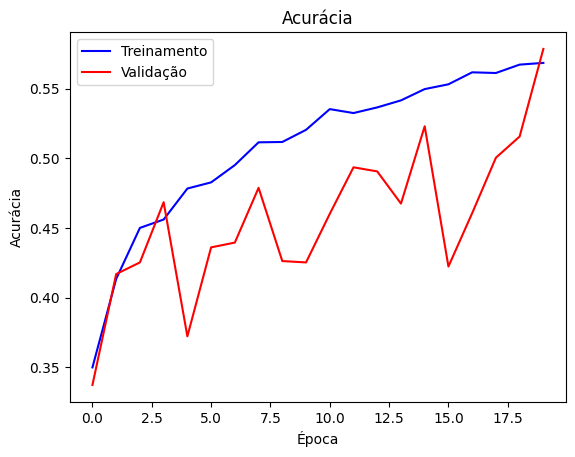

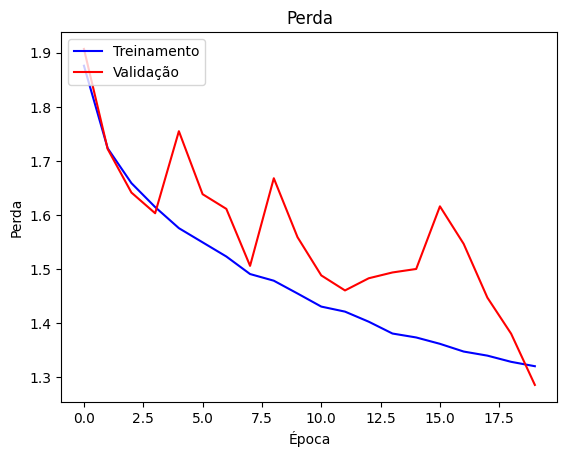

In [ ]:
historico = resnet_treino_base.history
acuracia_treino = historico['accuracy']
epocas_treino = historico['val_accuracy']
acuracia_perda = historico['loss']
acuracia_epocas = historico['val_loss']
mostrar_resultado_modelo("Modelo Resnet Base", acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas)

----------------------------RESULTADO-MODELOS----------------------------

--Modelo Resnet Gradiente--

Acurácias durante o treinamento:
['10.59%', '15.70%', '23.02%', '25.82%', '27.79%', '28.57%', '30.01%', '30.10%', '30.76%', '30.75%', '31.04%', '31.33%', '31.70%', '31.92%', '32.52%', '33.16%', '33.02%', '33.70%', '33.92%', '34.08%']

Perdas durante o treinamento:
['2.42', '2.27', '2.19', '2.14', '2.10', '2.07', '2.05', '2.03', '2.02', '2.00', '1.99', '1.98', '1.97', '1.96', '1.95', '1.95', '1.94', '1.94', '1.93', '1.93']




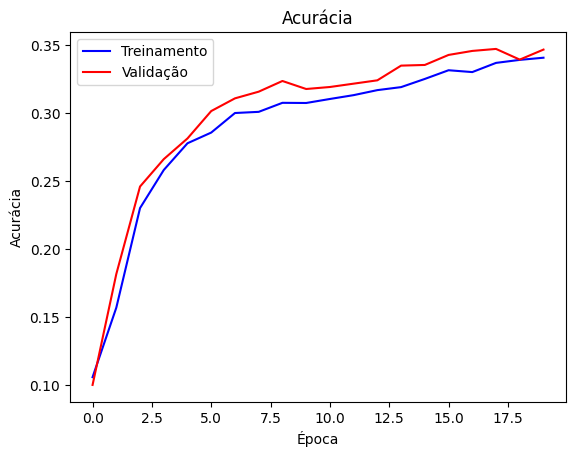

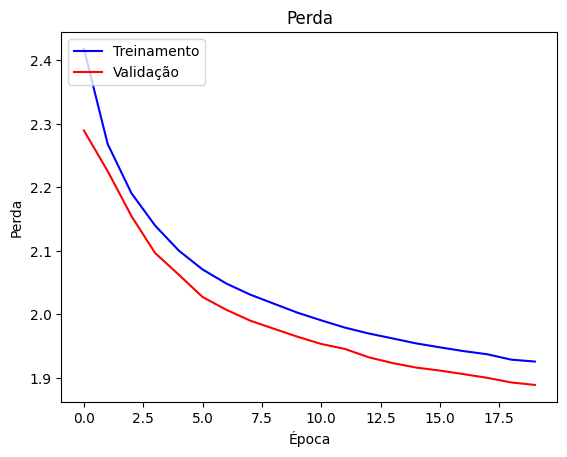

In [ ]:
historico = resnet_treino_gradiente.history
acuracia_treino = historico['accuracy']
epocas_treino = historico['val_accuracy']
acuracia_perda = historico['loss']
acuracia_epocas = historico['val_loss']
mostrar_resultado_modelo("Modelo Resnet Gradiente", acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas)

----------------------------RESULTADO-MODELOS----------------------------

--Modelo Resnet Adam--

Acurácias durante o treinamento:
['28.07%', '36.98%', '39.75%', '40.48%', '42.24%', '43.28%', '43.88%', '44.07%', '44.72%', '45.12%', '46.29%', '46.22%', '46.39%', '47.48%', '47.10%', '47.71%', '48.61%', '48.28%', '48.71%', '48.78%']

Perdas durante o treinamento:
['2.03', '1.85', '1.80', '1.77', '1.75', '1.73', '1.72', '1.71', '1.69', '1.68', '1.67', '1.66', '1.65', '1.64', '1.63', '1.62', '1.61', '1.60', '1.59', '1.59']




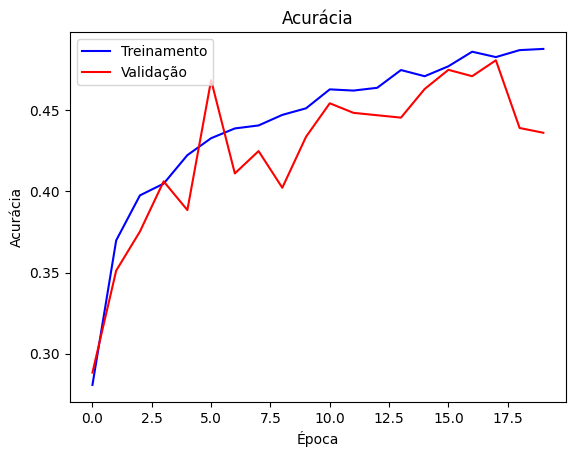

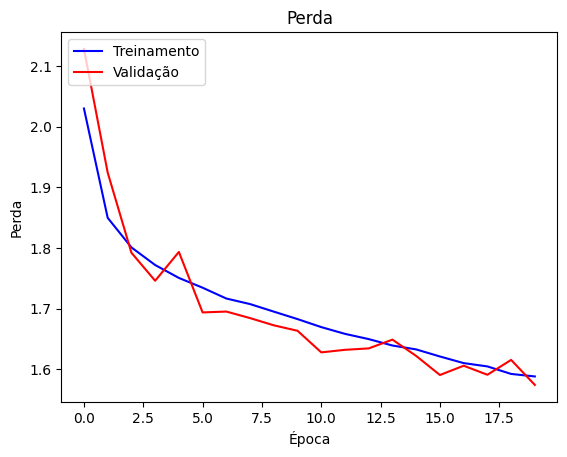

In [ ]:
historico = resnet_treino_adam.history
acuracia_treino = historico['accuracy']
epocas_treino = historico['val_accuracy']
acuracia_perda = historico['loss']
acuracia_epocas = historico['val_loss']
mostrar_resultado_modelo("Modelo Resnet Adam", acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas)

In [ ]:
caminho_modelo = caminho_base + '/ModeloBaseResNet.h5'
classificador_resnet_base.save(caminho_modelo)

In [ ]:
caminho_modelo = caminho_base + '/ModeloGradienteResNet.h5'
classificador_resnet_gradiente.save(caminho_modelo)

In [ ]:
caminho_modelo = caminho_base + '/ModeloAdamResNet.h5'
classificador_resnet_adam.save(caminho_modelo)